In [1]:
# Importing required libraries
import nltk
import re
from nltk.corpus import stopwords
import pandas as pd
import random
from gensim.models import Word2Vec
from nltk import word_tokenize
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn            as sns
import numpy as np
import os


SEED_VALUE = 55
random.seed(SEED_VALUE)
os.environ["PYTHONHASHSEED"] = str(SEED_VALUE)
np.random.seed(SEED_VALUE)
nltk.download('punkt')
nltk.download("stopwords")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Uploading the first datset ('med_devs_clean_data.csv')
from google.colab import files
uploaded = files.upload()

Saving med_devs_clean_data.csv to med_devs_clean_data (1).csv


In [70]:
# Reading the datset from the csv file into dataframe
df = pd.read_csv('med_devs_clean_data.csv')

In [4]:
# Cheking the dataframe
df.head()

,Name,Description,Category
0,Implantable loop recorder,"An implantable loop recorder (ILR), also known...",Implants (medicine)
1,Health Canada,"Health Canada (HC; French: Santé Canada, SC) i...",Regulation of medical devices
2,Visual prosthesis,"A visual prosthesis, often referred to as a bi...","Implants (medicine),Neuroprosthetics"
3,Medical Devices Directive,The Medical Device Directive (Council Directiv...,Regulation of medical devices
4,Nasal spray,Nasal sprays are used to deliver medications l...,"Drug delivery devices,Nasal sprays"


In [5]:
# Randomly checking for the description column value
df['Description'][36]

'Total Annihilation is a real-time strategy video game created by Cavedog Entertainment, a sub-division of Humongous Entertainment, and was released on September 26, 1997 by GT Interactive for Microsoft Windows and Mac OS. Two expansion packs were released, The Core Contingency on April 28, 1998 and Battle Tactics on June 30. After the closure of the Cavedog Entertainment in 1999, the intellectual property fell to Infogrames (now Atari). Total Annihilation is no longer officially supported, due to the closure of Cavedog. Former lead designer Chris Taylor went on with Gas Powered Games to create Supreme Commander in 2007, considered the "spiritual successor" of Total Annihilation. The creators of XTA, a mod for Total Annihilation, independently developed the open-source 3D graphics Spring game engine. The Total Annihilation 3D project began in 2006. Other ex-members of Cavedog, including Total Annihilation\'s game engine developer Jon Mavor, later went on to develop Planetary Annihilati

In [6]:
# Randomly checking for the Category column value
df['Category'][36]

'Cyborgs in fiction'

In [7]:
# Uploading the second dataset ('med_equips_clean_data')
from google.colab import files
uploaded = files.upload()

Saving med_equips_clean_data.csv to med_equips_clean_data (1).csv


In [8]:
# Reading the dataset into a dataframe
df1 = pd.read_csv('med_equips_clean_data.csv')
df1.head(3)

,Name,Description,Category
0,Cephalometry,Cephalometry is the study and measurement of t...,Medical imaging
1,Cephalotribe,A cephalotribe was a medical instrument used i...,Surgical instruments
2,Implantable loop recorder,"An implantable loop recorder (ILR), also known...","Cardiac electrophysiology,Implants (medicine),..."


In [9]:
# Combining the both daasets in single dataframe
medical_data = pd.concat([df, df1], axis=0,ignore_index=True)
medical_data.shape

(1804, 3)

In [10]:
# Converting first three columns into a single column 'text_data'
medical_data['text_data'] = medical_data['Name'].astype(str).str.cat(medical_data['Description'].astype(str).str.cat(medical_data['Category']), sep=',')
medical_data.head()

,Name,Description,Category,text_data
0,Implantable loop recorder,"An implantable loop recorder (ILR), also known...",Implants (medicine),"Implantable loop recorder,An implantable loop ..."
1,Health Canada,"Health Canada (HC; French: Santé Canada, SC) i...",Regulation of medical devices,"Health Canada,Health Canada (HC; French: Santé..."
2,Visual prosthesis,"A visual prosthesis, often referred to as a bi...","Implants (medicine),Neuroprosthetics","Visual prosthesis,A visual prosthesis, often r..."
3,Medical Devices Directive,The Medical Device Directive (Council Directiv...,Regulation of medical devices,"Medical Devices Directive,The Medical Device D..."
4,Nasal spray,Nasal sprays are used to deliver medications l...,"Drug delivery devices,Nasal sprays","Nasal spray,Nasal sprays are used to deliver m..."


In [11]:
# Checking for the number of rows and columns in a medical dataset
medical_data.shape

(1804, 4)

In [12]:
# Dropping if any duplicate records
med_data =medical_data.drop_duplicates(subset=['text_data'],ignore_index=True)

In [13]:
# Reading the first three records 
med_data.head(3)

,Name,Description,Category,text_data
0,Implantable loop recorder,"An implantable loop recorder (ILR), also known...",Implants (medicine),"Implantable loop recorder,An implantable loop ..."
1,Health Canada,"Health Canada (HC; French: Santé Canada, SC) i...",Regulation of medical devices,"Health Canada,Health Canada (HC; French: Santé..."
2,Visual prosthesis,"A visual prosthesis, often referred to as a bi...","Implants (medicine),Neuroprosthetics","Visual prosthesis,A visual prosthesis, often r..."


In [14]:
#After deletion of the duplicate records, checking the number of records
med_data.shape

(1500, 4)

In [15]:
# Checking the main column to proceed for further operations
med_data['text_data']

0       Implantable loop recorder,An implantable loop ...
1       Health Canada,Health Canada (HC; French: Santé...
2       Visual prosthesis,A visual prosthesis, often r...
3       Medical Devices Directive,The Medical Device D...
4       Nasal spray,Nasal sprays are used to deliver m...
                              ...                        
1495    Iohexol,Iohexol, sold under the trade name Omn...
1496    Iopanoic acid,Iopanoic acid is an iodine-conta...
1497    Iopydol,Iopydol is a pharmaceutical drug used ...
1498    Iotalamic acid,Iotalamic acid (USAN: iothalami...
1499    Ioxitalamic acid,Ioxitalamic acid (brand name ...
Name: text_data, Length: 1500, dtype: object

In [16]:
# Reading the first record
med_data.loc[0, "text_data"]

"Implantable loop recorder,An implantable loop recorder (ILR), also known as an insertable cardiac monitor (ICM), is a small device about the size of a pack of chewing gum or USB memory stick that is implanted just under the skin of the chest for cardiac monitoring (that is, to record the heart's electrical activity).Implants (medicine)"

In [17]:
# Removing of unwanted infromation with the help of regular expression and NLTK library

corpus =[]

for i in range(len(med_data['text_data'])):
    subject = med_data.loc[i, "text_data"]
    subject = subject.lower()
    subject = re.sub('[^a-zA-Z]',' ',subject)
    subject = re.sub(r"\s+", " ", subject)  # to  remove multiple spaces--
    subject = re.sub(r"\w+…|…", "", subject)  # to remove ellipsis--
    subject = re.sub(r"(?<=\w)-(?=\w)", " ", subject) # to  replace dash between words
    subject = subject.split()
    subject = [(word) for word in subject if not word in set(stopwords.words('english')+ ['used','use','using','also','may','known', 'one','two'] )] #To remove stop words
    subject =' '.join(subject)
    corpus.append(subject)

In [18]:
#Reading the processed data after removing noise.
corpus[0:2]

['implantable loop recorder implantable loop recorder ilr insertable cardiac monitor icm small device size pack chewing gum usb memory stick implanted skin chest cardiac monitoring record heart electrical activity implants medicine',
 'health canada health canada hc french sant canada sc department government canada responsible national health policy department responsible numerous federal health related agencies including canadian food inspection agency cfia public health agency canada phac among others organizations help ensure compliance federal law variety healthcare agricultural pharmaceutical activities responsibility involves extensive collaboration various federal provincial level organizations order ensure safety food health pharmaceutical products including regulation health research pharmaceutical manufacturing testing facilities department responsible parliament minister health presently patty hajdu part federal health portfolio deputy minister health senior civil servant w

In [19]:
# Tokenization of the text data

tokenized_data=[]
for i in range(len(corpus)):
  tokens = word_tokenize(str(corpus[i]))
  tokenized_data.append(tokens)


In [20]:
# Checking tokenized data
print(tokenized_data[0:2])

[['implantable', 'loop', 'recorder', 'implantable', 'loop', 'recorder', 'ilr', 'insertable', 'cardiac', 'monitor', 'icm', 'small', 'device', 'size', 'pack', 'chewing', 'gum', 'usb', 'memory', 'stick', 'implanted', 'skin', 'chest', 'cardiac', 'monitoring', 'record', 'heart', 'electrical', 'activity', 'implants', 'medicine'], ['health', 'canada', 'health', 'canada', 'hc', 'french', 'sant', 'canada', 'sc', 'department', 'government', 'canada', 'responsible', 'national', 'health', 'policy', 'department', 'responsible', 'numerous', 'federal', 'health', 'related', 'agencies', 'including', 'canadian', 'food', 'inspection', 'agency', 'cfia', 'public', 'health', 'agency', 'canada', 'phac', 'among', 'others', 'organizations', 'help', 'ensure', 'compliance', 'federal', 'law', 'variety', 'healthcare', 'agricultural', 'pharmaceutical', 'activities', 'responsibility', 'involves', 'extensive', 'collaboration', 'various', 'federal', 'provincial', 'level', 'organizations', 'order', 'ensure', 'safety', 

In [21]:
# Counting the number of vocabulary
from collections import Counter
docs = corpus
# tokenized_docs = all_keywords
tokenized_docs = tokenized_data
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [22]:
# Total number of vocabulary
len(vocab)

16846

In [23]:
# Most common words (Top ten)
vocab.most_common(10)


[('medical', 1202),
 ('imaging', 732),
 ('device', 514),
 ('devices', 413),
 ('brain', 385),
 ('medicine', 344),
 ('x', 338),
 ('surgical', 325),
 ('heart', 321),
 ('system', 312)]

In [24]:
#Installing word2vec module
!pip install word2vec


In [25]:
#Building model using word2vec
from gensim.models import Word2Vec
Word2Vecmodel = Word2Vec(sentences=tokenized_data, workers=1)

In [26]:
#Coverting the vocabuary into list produced by Word2Vec model
words = list(Word2Vecmodel.wv.vocab)
print(words)

['implantable', 'loop', 'recorder', 'cardiac', 'monitor', 'small', 'device', 'size', 'memory', 'stick', 'implanted', 'skin', 'chest', 'monitoring', 'record', 'heart', 'electrical', 'activity', 'implants', 'medicine', 'health', 'canada', 'french', 'department', 'government', 'responsible', 'national', 'policy', 'numerous', 'federal', 'related', 'agencies', 'including', 'canadian', 'food', 'inspection', 'agency', 'public', 'among', 'others', 'organizations', 'help', 'ensure', 'compliance', 'law', 'variety', 'healthcare', 'pharmaceutical', 'activities', 'involves', 'extensive', 'collaboration', 'various', 'level', 'order', 'safety', 'products', 'regulation', 'research', 'manufacturing', 'testing', 'facilities', 'minister', 'part', 'within', 'day', 'leadership', 'operations', 'reports', 'directly', 'originally', 'created', 'spanish', 'flu', 'today', 'formed', 'former', 'established', 'split', 'separate', 'units', 'human', 'resources', 'medical', 'devices', 'visual', 'prosthesis', 'often', 

In [27]:
# Checking for the  word similarity to any random word E.g., devices
Word2Vecmodel.wv.most_similar("devices")

[('regulation', 0.9994351863861084),
 ('administration', 0.9994300007820129),
 ('food', 0.9994127154350281),
 ('illustrators', 0.9993652701377869),
 ('pumps', 0.9993317127227783),
 ('fda', 0.9993079900741577),
 ('iso', 0.9993067979812622),
 ('management', 0.9993003606796265),
 ('emergency', 0.9992989301681519),
 ('approved', 0.9992572069168091)]

In [28]:
# Transforming the tokenized words into vectors
import numpy as np
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
# vectorized_docs = vectorize(all_keywords, model=model)
vectorized_docs = vectorize(tokenized_data, model=Word2Vecmodel)
len(vectorized_docs), len(vectorized_docs[0])

(1500, 100)

# **Implementation of K-means algorithm** 




In [29]:
# Running for loop for a range of clusters to be build in K-means algorithm 
from sklearn.cluster import KMeans
sil = []
wcss = []
cls_num = 13
for i in range(2,cls_num):
    
    knn_model = KMeans(n_clusters=i, init="k-means++", max_iter=100, n_init=1)
    
    knn_model.fit(vectorized_docs)
    
    wcss.append(knn_model.inertia_) # WSS score
    labels = knn_model.labels_ # Silhouette score
    sil.append(silhouette_score(vectorized_docs, labels, metric = 'euclidean'))

Text(0, 0.5, 'WCSS: Within-cluster Sum of Squares')

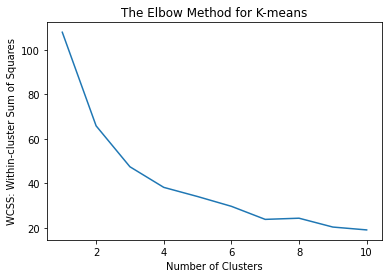

In [30]:
# Plot the number of clusters vs WCSS
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score



number_clusters = range(1,11)
plt.plot(number_clusters,wcss[0:10])
plt.title('The Elbow Method for K-means')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS: Within-cluster Sum of Squares')

Text(0, 0.5, 'Silhouette score')

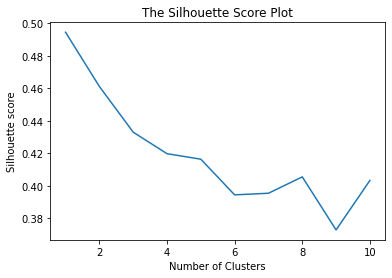

In [31]:
# Plot solhouette score




number_clusters = range(1,11)
plt.plot(number_clusters,sil[0:10])
plt.title('The Silhouette Score Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')

In [32]:
# Printing silhouette scoore
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.metrics as metrics
wcss = []
for i in range(3,15):
    labels=KMeans(n_clusters=i,init="k-means++",random_state=200).fit(vectorized_docs).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(vectorized_docs,labels,metric="euclidean",sample_size=1000,random_state=200)))
    

Silhouette score for k(clusters) = 3 is 0.45514557
Silhouette score for k(clusters) = 4 is 0.43596256
Silhouette score for k(clusters) = 5 is 0.4058234
Silhouette score for k(clusters) = 6 is 0.40116224
Silhouette score for k(clusters) = 7 is 0.3880211
Silhouette score for k(clusters) = 8 is 0.40061268
Silhouette score for k(clusters) = 9 is 0.3645614
Silhouette score for k(clusters) = 10 is 0.38405347
Silhouette score for k(clusters) = 11 is 0.35411888
Silhouette score for k(clusters) = 12 is 0.3706442
Silhouette score for k(clusters) = 13 is 0.35486498
Silhouette score for k(clusters) = 14 is 0.35313916


For n_clusters = 3 The average silhouette_score is : 0.45514557
For n_clusters = 4 The average silhouette_score is : 0.43596256
For n_clusters = 5 The average silhouette_score is : 0.4058234
For n_clusters = 6 The average silhouette_score is : 0.40116224
For n_clusters = 7 The average silhouette_score is : 0.3880211
For n_clusters = 8 The average silhouette_score is : 0.40061268
For n_clusters = 9 The average silhouette_score is : 0.3645614
For n_clusters = 10 The average silhouette_score is : 0.38405347


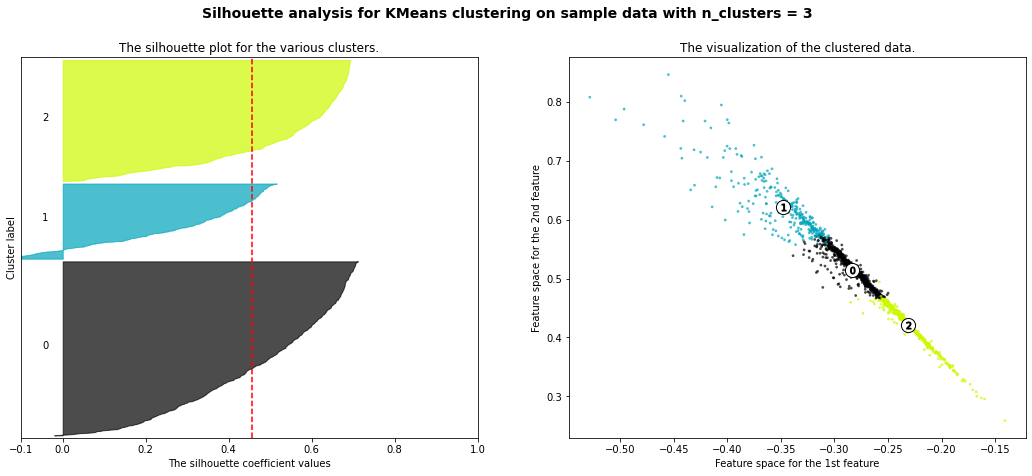

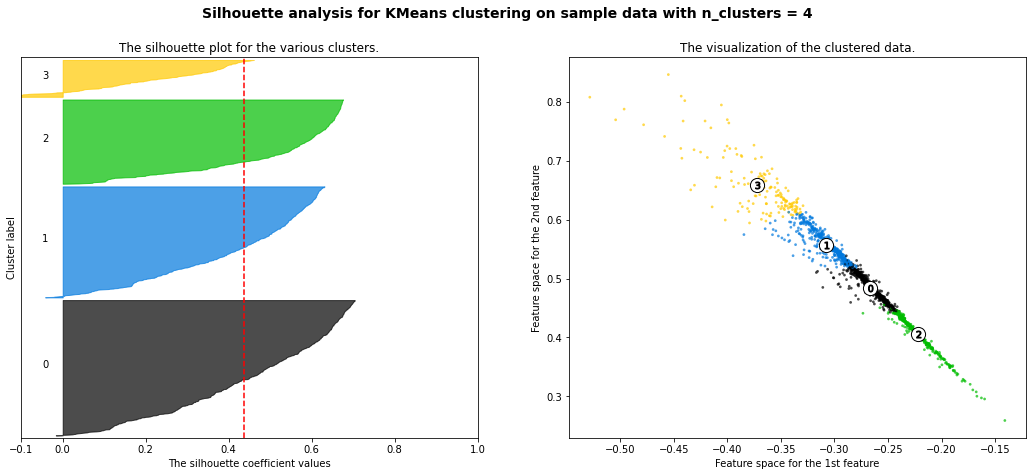

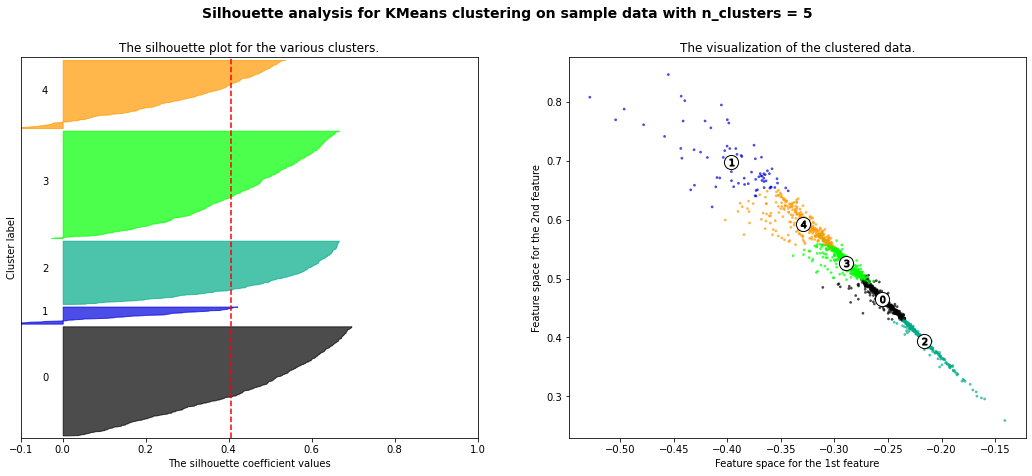

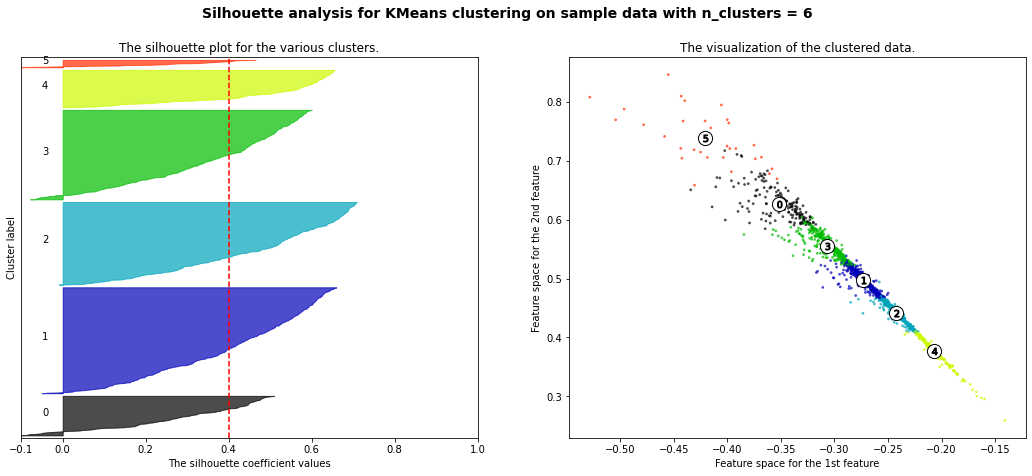

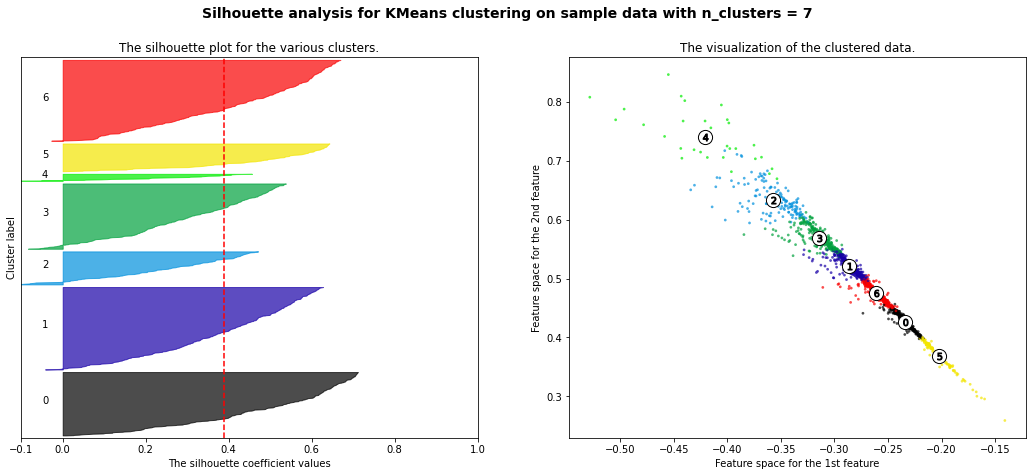

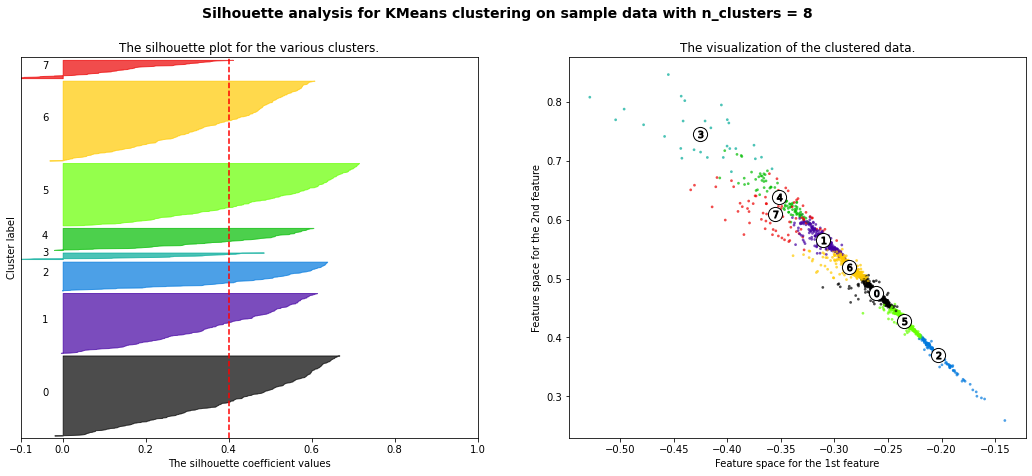

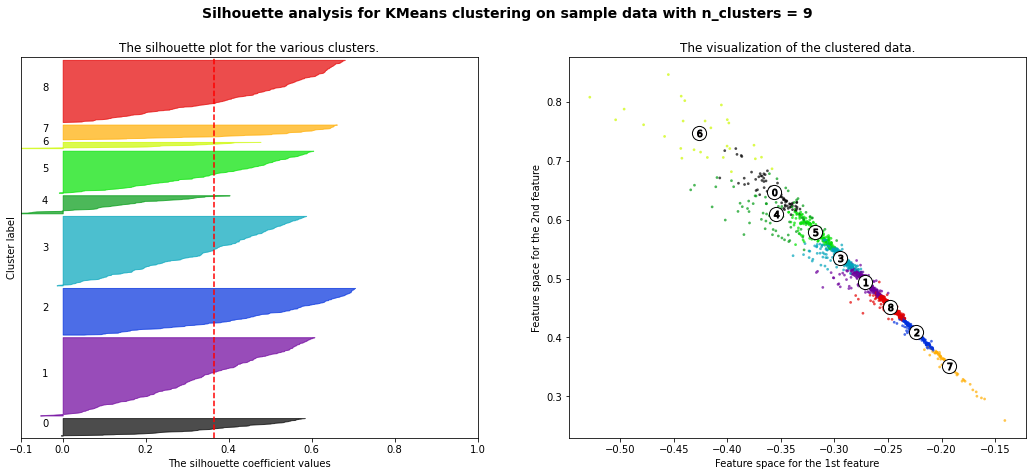

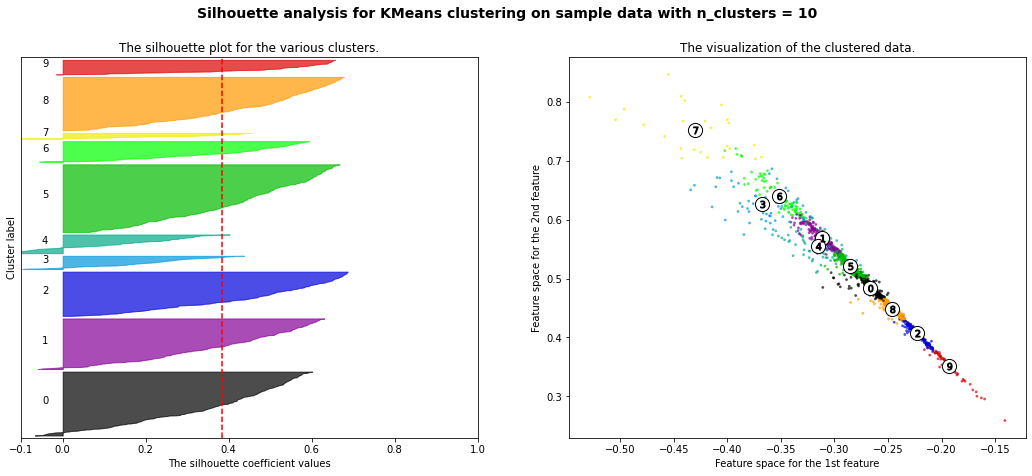

In [33]:
# Visualizing average silhouette score and clustering analysis
random.seed(SEED_VALUE)
X = np.array(vectorized_docs)
range_n_clusters = [3,4,5,6,7,8,9,10]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,init="k-means++", random_state=200)
    cluster_labels = clusterer.fit_predict(X)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels,metric='euclidean',sample_size=1000,random_state=200)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [34]:
# K-means function defined for qualitative analysis
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
def mbkmeans_clusters(
	X, 
    k, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using Kmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        print_silhouette_values: Print silhouette values per cluster.

    """
    km = KMeans(n_clusters=k,init="k-means++", random_state=200).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [35]:
# Running k-means model which results into a dataframe 
docs = med_data['text_data'].values
clustering, cluster_labels = mbkmeans_clusters(
	X=np.array(vectorized_docs),
    k=20,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 20
Silhouette coefficient: 0.34
Inertia:10.496503829956055
Silhouette values:
    Cluster 3: Size:44 | Avg:0.50 | Min:0.02 | Max: 0.71
    Cluster 18: Size:11 | Avg:0.49 | Min:0.16 | Max: 0.66
    Cluster 14: Size:5 | Avg:0.45 | Min:0.23 | Max: 0.57
    Cluster 13: Size:97 | Avg:0.44 | Min:0.02 | Max: 0.68
    Cluster 19: Size:6 | Avg:0.41 | Min:0.24 | Max: 0.57
    Cluster 8: Size:170 | Avg:0.40 | Min:0.03 | Max: 0.65
    Cluster 16: Size:158 | Avg:0.39 | Min:0.01 | Max: 0.65
    Cluster 1: Size:142 | Avg:0.39 | Min:-0.03 | Max: 0.65
    Cluster 0: Size:63 | Avg:0.38 | Min:-0.01 | Max: 0.60
    Cluster 6: Size:154 | Avg:0.37 | Min:0.01 | Max: 0.62
    Cluster 2: Size:162 | Avg:0.31 | Min:-0.02 | Max: 0.55
    Cluster 15: Size:24 | Avg:0.30 | Min:-0.01 | Max: 0.55
    Cluster 9: Size:31 | Avg:0.29 | Min:-0.01 | Max: 0.49
    Cluster 11: Size:34 | Avg:0.29 | Min:0.01 | Max: 0.51
    Cluster 17: Size:155 | Avg:0.28 | Min:-0.05 | Max: 0.54
    Cluster 12: Size:120 | Avg:0

In [36]:
# Checking the dataframe formed
df_clusters.head()

,text,tokens,cluster
0,"Implantable loop recorder,An implantable loop ...",implantable loop recorder implantable loop rec...,0
1,"Health Canada,Health Canada (HC; French: Santé...",health canada health canada hc french sant can...,17
2,"Visual prosthesis,A visual prosthesis, often r...",visual prosthesis visual prosthesis often refe...,2
3,"Medical Devices Directive,The Medical Device D...",medical devices directive medical device direc...,17
4,"Nasal spray,Nasal sprays are used to deliver m...",nasal spray nasal sprays deliver medications l...,16


In [37]:
# Evaluate top terms per cluster (based on clusters' centroids)
print("Most representative terms per cluster (based on centroids):")
for i in range(20):
    tokens_per_cluster = ""
    most_representative = Word2Vecmodel.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: studies including non technology applications 
Cluster 1: including data general national materials 
Cluster 2: including general national data software 
Cluster 3: including general work national data 
Cluster 4: mri nmr imaging functional spectroscopic 
Cluster 5: scanners pet coherence medium contrast 
Cluster 6: general national work including system 
Cluster 7: technique techniques optical scans scanner 
Cluster 8: general work include number national 
Cluster 9: studies based technology development application 
Cluster 10: technique techniques optical scans scanner 
Cluster 11: medium scanners pet coherence photon 
Cluster 12: including national general software information 
Cluster 13: general including work national data 
Cluster 14: ct rays scanners positron fluoroscopy 
Cluster 15: functional spectroscopy technique techniques fmri 
Cluster 16: including general work data materials 
Cluster 17: including na

In [38]:
# Evaluate top terms per cluster (based on words frequencies)
for i in range(20):
    tokens_per_cluster = ""
    most_frequent = Counter(" ".join(df_clusters.query(f"cluster == {i}")["tokens"]).split()).most_common(5)
    for t in most_frequent:
        tokens_per_cluster += f"{t[0]}({str(t[1])}) "
    print(f"Cluster {i}: {tokens_per_cluster}")

Cluster 0: medical(56) brain(32) implants(30) imaging(26) cardiac(25) 
Cluster 1: medical(72) devices(44) device(41) game(41) made(27) 
Cluster 2: medical(151) device(72) brain(70) imaging(49) medicine(48) 
Cluster 3: alita(15) medical(13) battle(13) shopping(12) cart(12) 
Cluster 4: imaging(32) magnetic(30) resonance(30) mri(8) cardiac(7) 
Cluster 5: x(35) imaging(29) tomography(26) ray(25) contrast(23) 
Cluster 6: medical(207) device(95) devices(81) blood(71) heart(70) 
Cluster 7: imaging(66) magnetic(53) x(45) mri(42) ray(38) 
Cluster 8: medical(115) surgical(66) surgery(44) patients(43) medicine(43) 
Cluster 9: medical(37) radiation(22) imaging(17) devices(15) medicine(15) 
Cluster 10: imaging(147) tomography(60) magnetic(51) medical(46) x(46) 
Cluster 11: x(114) ray(92) ct(53) tomography(52) imaging(40) 
Cluster 12: medical(114) potential(81) membrane(68) device(65) heart(62) 
Cluster 13: medical(53) wheelchair(19) device(18) first(16) university(16) 
Cluster 14: x(8) computed(8) 

In [39]:
# Evaluate top terms per cluster (based on words frequencies)
test_cluster = 6
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:5]:
    print(docs[d])
    print("-------------")

Biomaterial,A biomaterial is a substance that has been engineered to interact with biological systems for a medical purpose, either a therapeutic (treat, augment, repair, or replace a tissue function of the body) or a diagnostic one. As a science, biomaterials is about fifty years old. The study of biomaterials is called biomaterials science or biomaterials engineering. It has experienced steady and strong growth over its history, with many companies investing large amounts of money into the development of new products. Biomaterials science encompasses elements of medicine, biology, chemistry, tissue engineering and materials science. Note that a biomaterial is different from a biological material, such as bone, that is produced by a biological system. Additionally, care should be exercised in defining a biomaterial as biocompatible, since it is application-specific. A biomaterial that is biocompatible or suitable for one application may not be biocompatible in another. IUPAC definitio

In [40]:
# Retrieve a random sample of documents for a given cluster
for i,t in enumerate(df_clusters.query(f"cluster == {test_cluster}").sample(4).iterrows()):
    print(t[1]["text"])
    print("-------------")

Dorothy Davison,Dorothy Davison (9 March 1889–4 February 1984) was a British author and medical illustrator, whose work was well known for its artistic merit. She founded the Medical Artists' Association in 1949, and trained many young medical artists in Manchester.Medical illustrators
-------------
Nuclear Medicine and Biology,Nuclear Medicine and Biology is a peer-reviewed medical journal published by Elsevier that covers research on all aspects of nuclear medicine, including radiopharmacology, radiopharmacy and clinical studies of targeted radiotracers. It is the official journal of the . According to the Journal Citation Reports, the journal has a 2011 impact factor of 3.023.Nuclear medicine
-------------
Subdermal implant,A subdermal implant refers to a body modification that is placed underneath the skin, therefore allowing the body to heal over the implant and creating a raised design. Such implants fall under the broad category of body modification. Many subdermal implants are 

# Once the optimal number of clusters were determined, with that number of cluster, model was re-run and quantative analysis was performed.

In [41]:
#K-means function
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
def mbkmeans_clusters(
	X, 
    k, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.
    """
    km =  KMeans(n_clusters=k, init="k-means++", max_iter=100, n_init=1).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    return km, km.labels_

In [42]:
#Running the model and creating dataframe with the assigned clusters
docs = med_data['Category'].values
docs1 = med_data['Name'].values
clustering, cluster_labels = mbkmeans_clusters(
	X=np.array(vectorized_docs),
    k=6,  #Optimal number of clusters
    print_silhouette_values=True,
)
df_cluster = pd.DataFrame({
    "Name": docs1,
    "category":docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 6
Silhouette coefficient: 0.40
Inertia:31.893911361694336


In [43]:
# Examining the records by obtaining the cluster values 
df_cluster.head()

,Name,category,tokens,cluster
0,Implantable loop recorder,Implants (medicine),implantable loop recorder implantable loop rec...,2
1,Health Canada,Regulation of medical devices,health canada health canada hc french sant can...,5
2,Visual prosthesis,"Implants (medicine),Neuroprosthetics",visual prosthesis visual prosthesis often refe...,0
3,Medical Devices Directive,Regulation of medical devices,medical devices directive medical device direc...,5
4,Nasal spray,"Drug delivery devices,Nasal sprays",nasal spray nasal sprays deliver medications l...,3


In [44]:
# Sorting the records according to the clusters
df_cluster.sort_values(by=['cluster'])

,Name,category,tokens,cluster
634,Betsy Bang,Medical illustrators,betsy bang betsy bang n e garrett american bio...,0
1137,John Mallard,Medical imaging,john mallard john rowland mallard obe frse fre...,0
271,BrainGate,Brain–computer interfacing,braingate braingate brain implant system built...,0
270,Open Bionics,Prosthetic manufacturers,open bionics open bionics uk based company dev...,0
816,Nuclear Medicine Communications,Nuclear medicine,nuclear medicine communications nuclear medici...,0
...,...,...,...,...
369,Craniofacial prosthesis,Implants (medicine),craniofacial prosthesis craniofacial prosthese...,5
366,Unique Device Identification,Regulation of medical devices,unique device identification unique device ide...,5
364,Vacuum mattress,Medical transport devices,vacuum mattress vacuum mattress vacmat medical...,5
375,Artificial urinary sphincter,Implants (medicine),artificial urinary sphincter artificial urinar...,5


In [45]:
# Dividing the records according to the clusters'

df_cluster1 =df_cluster[df_cluster['cluster'] ==0]
df_cluster2 =df_cluster[df_cluster['cluster'] ==1]
df_cluster3 =df_cluster[df_cluster['cluster'] ==2]
df_cluster4 =df_cluster[df_cluster['cluster'] ==3]
df_cluster5 =df_cluster[df_cluster['cluster'] ==4]
df_cluster6 =df_cluster[df_cluster['cluster'] ==5]
df_cluster7 =df_cluster[df_cluster['cluster'] ==6]



In [46]:
# Checking for the record counts according to the cluster
df_cluster1['category'].value_counts()

Electrophysiology                                       28
Implants (medicine)                                     24
Medical imaging                                         19
Medical ultrasonography                                 15
Radiocontrast agents                                    13
                                                        ..
Medical imaging,Optical imaging                          1
Optical imaging                                          1
Implants (medicine),Medical devices,Neuroprosthetics     1
Cyborgs in fiction                                       1
Medical masks                                            1
Name: category, Length: 102, dtype: int64

In [47]:
# Checking for the record counts according to the cluster
df_cluster2['category'].value_counts()

Medical illustrators                               15
Biomaterials                                       13
Cyborgs in fiction                                 10
Radiologic signs                                    8
Electrophysiology                                   5
Wheelchairs                                         5
Mobility devices                                    4
Electrophysiologists                                4
Medical ultrasonography                             4
Orthopedic braces                                   4
Medical dressings                                   3
Drug delivery devices                               3
Cyborgs                                             3
Ophthalmic equipment                                3
Orthodontic appliances                              3
Catheters                                           3
Surgical instruments                                3
Tinctures                                           3
Neuroimaging                

In [48]:
# Checking for the record counts according to the cluster
df_cluster3['category'].value_counts()

Medical imaging                                          24
Radiation therapy                                        12
Implants (medicine)                                       9
Radiocontrast agents                                      9
Medical device manufacturers                              7
                                                         ..
Anesthetic equipment                                      1
Medical imaging,Radiology                                 1
Cardiac electrophysiology,Catheters,Electrophysiology     1
Medical imaging,Medical ultrasonography                   1
Medical masks                                             1
Name: category, Length: 73, dtype: int64

In [49]:
# Checking for the record counts according to the cluster
df_cluster4['category'].value_counts()

Drug delivery devices                         27
Electrophysiology                             16
Cyborgs in fiction                            13
Implants (medicine)                           13
Biomaterials                                  13
                                              ..
Dental equipment,Orthodontic appliances        1
Dental practice management software            1
Medical drains                                 1
Magnetic resonance imaging,Medical imaging     1
Ophthalmic equipment,Optotypes                 1
Name: category, Length: 94, dtype: int64

In [50]:
# Checking for the record counts according to the cluster
df_cluster5['category'].value_counts()

Magnetic resonance imaging                              7
Radiocontrast agents                                    6
Medical imaging                                         4
MRI contrast agents                                     3
Nuclear medicine                                        2
X-ray computed tomography                               2
Radiology                                               1
Medical device manufacturers,Medical devices            1
Magnetic resonance imaging,Medical imaging,Radiology    1
Digestive system imaging,Magnetic resonance imaging     1
Nuclear medicine,Radiology                              1
Mobility devices                                        1
Radiology organizations                                 1
Contrast agents                                         1
Cardiac imaging,Magnetic resonance imaging              1
Respiratory system imaging,X-ray computed tomography    1
Tomography,X-ray computed tomography                    1
Magnetic reson

In [51]:
# Checking for the record counts according to the cluster
df_cluster6['category'].value_counts()

Implants (medicine)                                                               29
Electrophysiology                                                                 24
Drug delivery devices                                                             19
Medical imaging                                                                   14
Brain–computer interfacing                                                        13
                                                                                  ..
Cardiac electrophysiology,Implants (medicine),Medical devices,Neuroprosthetics     1
Implants (medicine),Medical devices,Neuroprosthetics                               1
Wheelchairs                                                                        1
Diabetes-related supplies and medical equipment,Medical monitoring equipment       1
Medical devices,Medical masks                                                      1
Name: category, Length: 110, dtype: int64

In [52]:
# Checking for the record counts according to the cluster
for i in range(6):
    print("Cluster:", i)
    print("The Members:", ' | '.join(list(df_cluster[df_cluster['cluster'] == i]['category'].values)))
    print("Total Members:", len(list(df_cluster[df_cluster['cluster'] == i]['category'].values)))
    print()

Cluster: 0
The Members: Implants (medicine),Neuroprosthetics | Implants (medicine) | Implants (medicine) | Biomaterials,Drug delivery devices | Implants (medicine) | Implants (medicine) | Medical masks | Mobility devices | Biomaterials | Brain–computer interfacing | Brain–computer interfacing | Regulation of medical devices | Drug delivery devices | Medical transport devices | Implants (medicine) | Brain–computer interfacing,Neuroprosthetics | Cyborgs in fiction | Prosthetic manufacturers | Implants (medicine),Neuroprosthetics | Regulation of medical devices | Regulation of medical devices | Brain–computer interfacing,Implants (medicine),Neuroprosthetics | Drug delivery devices | Implants (medicine) | Biomaterials,Implants (medicine) | Implants (medicine),Neuroprosthetics | Implants (medicine) | Implants (medicine) | Implants (medicine),Neuroprosthetics | Implants (medicine),Neuroprosthetics | Implants (medicine) | Biomaterials | Biomaterials,Implants (medicine) | Regulation of medical

In [53]:
# Checking for the record counts according to the cluster
for i in range(6):
    tokens_per_cluster = ""
    most_frequent = Counter(" ".join(df_cluster.query(f"cluster == {i}")["tokens"]).split()).most_common(5)
    for t in most_frequent:
        tokens_per_cluster += f"{t[0]}({str(t[1])}) "
    print(f"Cluster {i}: {tokens_per_cluster}")

Cluster 0: medical(396) imaging(232) device(166) heart(138) devices(137) 
Cluster 1: medical(63) first(23) wheelchair(21) device(18) series(17) 
Cluster 2: imaging(202) medical(195) x(115) ray(91) device(76) 
Cluster 3: medical(152) devices(96) device(96) brain(84) game(70) 
Cluster 4: imaging(78) x(40) magnetic(39) resonance(37) tomography(37) 
Cluster 5: medical(369) imaging(158) device(153) surgical(138) devices(115) 


In [54]:
# Extracting documents according to the cluster
test_cluster = 1
most_rep_categories = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_rep_categories[:10]:
    print(docs1[d],"--",docs[d])
    print("-------------")

Mitra personal mover -- Mobility devices
-------------
Akers' clasp -- Dental equipment
-------------
Pill organizer -- Medicine storage containers
-------------
Wheelchair trainer -- Wheelchairs
-------------
Hybrid Insect Micro-Electro-Mechanical Systems -- Cyborgs
-------------
Alginate dressing -- Medical dressings
-------------
Intrauterine pressure catheter -- Catheters
-------------
Obadiah Short -- Medical illustrators
-------------
Mindball -- Brain–computer interfacing
-------------
Snellen chart -- Optotypes
-------------


In [55]:
# Extracting name of the device according to the cluster
for i,t in enumerate(df_cluster.query(f"cluster == {test_cluster}").sample(6).iterrows()):
    print(t[1]["Name"])
    print("-------------")

Victor Stone (DC Extended Universe)
-------------
Alginate dressing
-------------
Ian Donald
-------------
Hydroxyethyl starch
-------------
Lip balm
-------------
Marie Marguerite Bihéron
-------------


## Implemenation of  K-medoids algorithm

In [56]:
#Downloading scikit-learn-extra library for K-medoids 
!pip install scikit-learn-extra

In [57]:
# Running K-medoids algorithm 
from sklearn_extra.cluster import KMedoids
sil =[]
wcss = []
cl_num = 20
for i in range(2,cl_num):
    
    kmedoids = KMedoids(n_clusters=i, random_state=0,metric='euclidean', init='heuristic')
    
    kmedoids.fit(vectorized_docs)
    
    wcss.append(kmedoids.inertia_) # WSS
    labels = kmedoids.labels_ 
    sil.append(silhouette_score(vectorized_docs, labels, metric = 'euclidean')) # Silhouette score

Text(0, 0.5, 'WCSS: Within-cluster Sum of Squares')

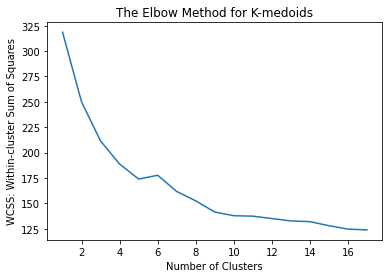

In [58]:
# Plot the number of clusters vs WCSS

number_clusters = range(1,18)
plt.plot(number_clusters,wcss[0:17])
plt.title('The Elbow Method for K-medoids')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS: Within-cluster Sum of Squares')

Text(0, 0.5, 'Silhouette score')

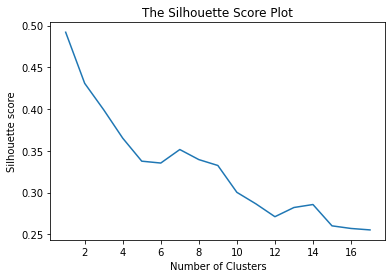

In [59]:
# Plot solhouette score
number_clusters = range(1,18)
plt.plot(number_clusters,sil[0:17])
plt.title('The Silhouette Score Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette score')

For n_clusters = 3 The average silhouette_score is : 0.2554865
For n_clusters = 4 The average silhouette_score is : 0.25860587
For n_clusters = 5 The average silhouette_score is : 0.2607984
For n_clusters = 6 The average silhouette_score is : 0.2563889
For n_clusters = 7 The average silhouette_score is : 0.28347313
For n_clusters = 8 The average silhouette_score is : 0.28166467


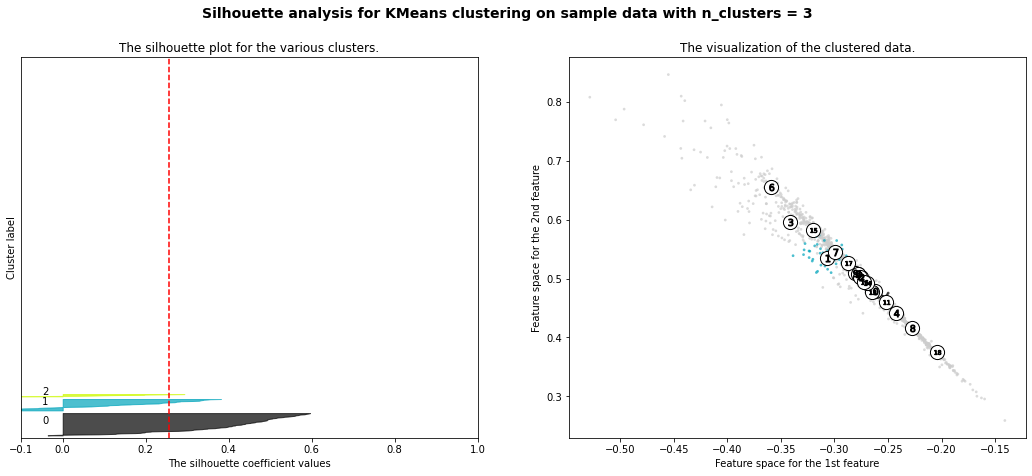

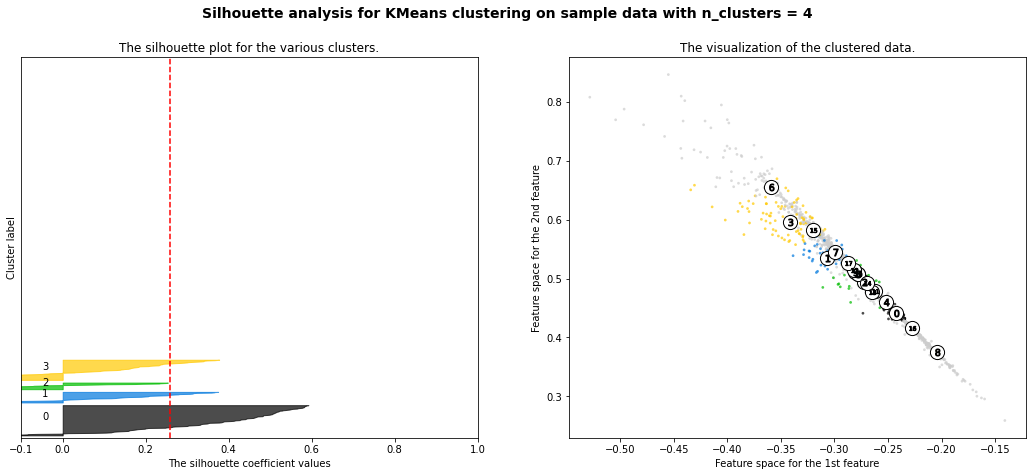

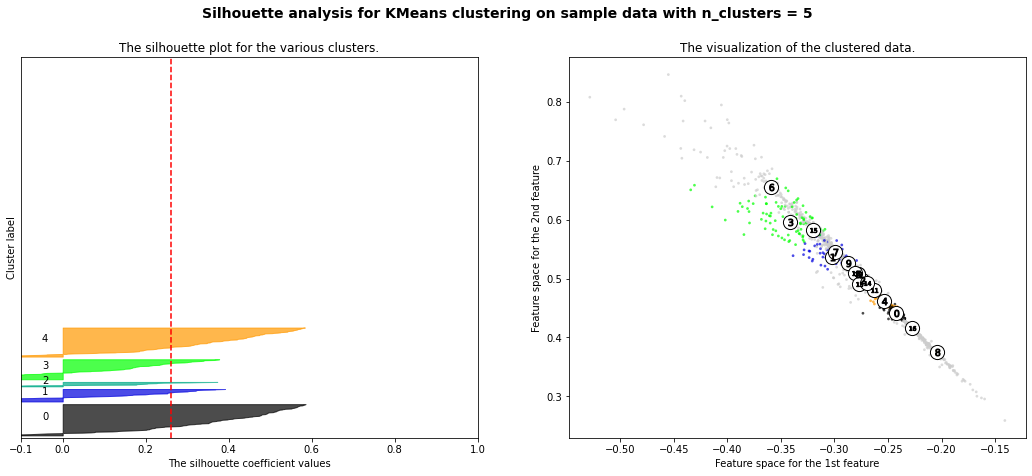

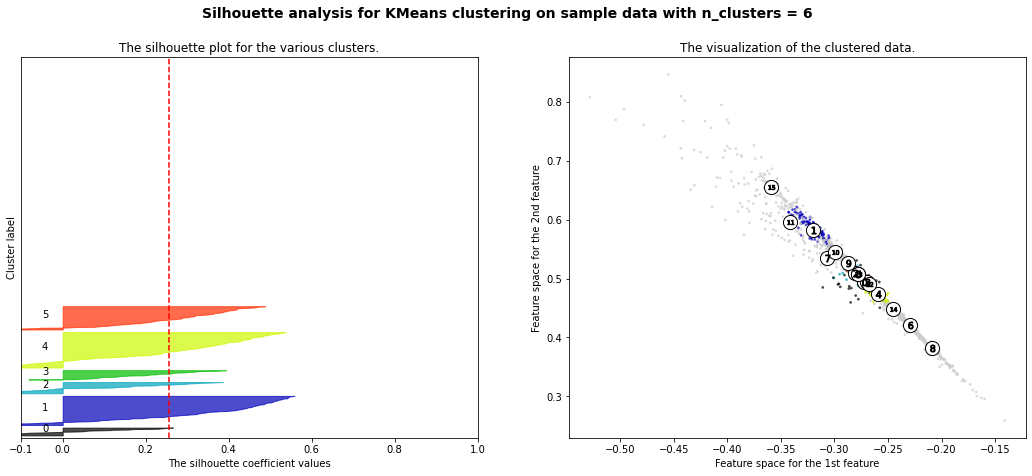

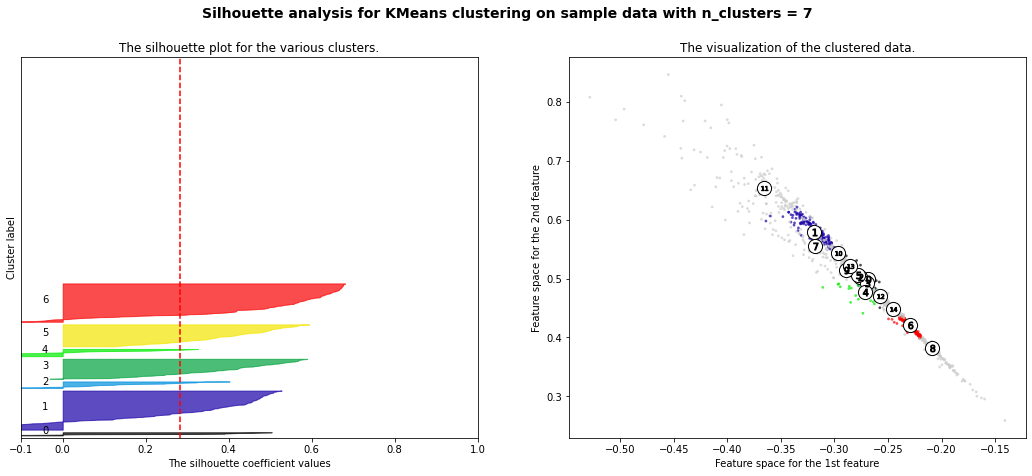

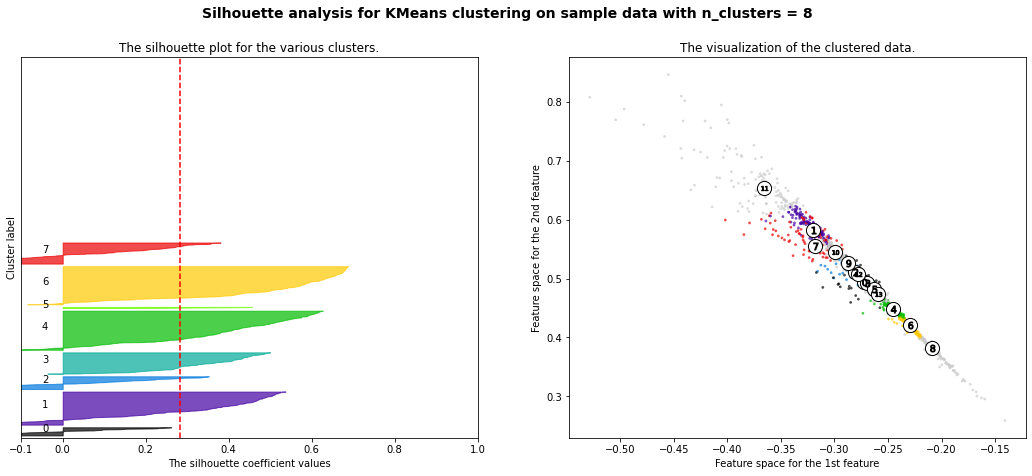

In [60]:
# Visualizing average silhouette coefficients and clustering analysis
X = np.array(vectorized_docs)
for n_clusters in range(3,9):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMedoids(n_clusters=i, random_state=0,metric='euclidean', init='heuristic')
    cluster_labels = clusterer.fit_predict(X)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels,metric='euclidean',sample_size=1000,random_state=200)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [61]:
#Defining k-medoids function to perform quantative analysis
from sklearn_extra.cluster import KMedoids

def k_medoids(
	X, 
    k, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    kmedoids = KMedoids(n_clusters=k, random_state=0,metric='euclidean', init='heuristic',).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, kmedoids.labels_):0.2f}")
    print(f"Inertia:{kmedoids.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, kmedoids.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[kmedoids.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
          try:  
              print( 
                    f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
          except ValueError:
            pass
    return kmedoids, kmedoids.labels_

In [62]:
# Running K-medoids and generating data frames for the clustering
docs = med_data['text_data'].values
from sklearn.metrics import silhouette_samples, silhouette_score

clustering, cluster_labels = k_medoids(
	X=np.array(vectorized_docs),
    k=15,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 15
Silhouette coefficient: 0.29
Inertia:131.992919921875
Silhouette values:
    Cluster 6: Size:160 | Avg:0.47 | Min:-0.14 | Max: 0.68
    Cluster 14: Size:155 | Avg:0.40 | Min:-0.09 | Max: 0.65
    Cluster 5: Size:92 | Avg:0.39 | Min:0.12 | Max: 0.59
    Cluster 3: Size:84 | Avg:0.38 | Min:-0.03 | Max: 0.59
    Cluster 10: Size:137 | Avg:0.36 | Min:-0.17 | Max: 0.58
    Cluster 12: Size:145 | Avg:0.34 | Min:-0.11 | Max: 0.61
    Cluster 8: Size:125 | Avg:0.32 | Min:-0.36 | Max: 0.58
    Cluster 13: Size:108 | Avg:0.26 | Min:-0.21 | Max: 0.51
    Cluster 1: Size:163 | Avg:0.25 | Min:-0.33 | Max: 0.53
    Cluster 0: Size:14 | Avg:0.20 | Min:-0.27 | Max: 0.50
    Cluster 2: Size:28 | Avg:0.13 | Min:-0.18 | Max: 0.40
    Cluster 9: Size:39 | Avg:0.06 | Min:-0.38 | Max: 0.36
    Cluster 7: Size:86 | Avg:0.03 | Min:-0.42 | Max: 0.39
    Cluster 11: Size:133 | Avg:0.03 | Min:-0.45 | Max: 0.37
    Cluster 4: Size:31 | Avg:-0.03 | Min:-0.45 | Max: 0.33


In [63]:
print("Top terms per cluster (based on centroids):")
for i in range(15):
    tokens_per_cluster = ""
    most_representative = Word2Vecmodel.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Top terms per cluster (based on centroids):
Cluster 0: functional spectroscopy fmri technique spin 
Cluster 1: national general systems including software 
Cluster 2: diagnosis institute development based studies 
Cluster 3: various well new products include 
Cluster 4: images produced digital uses motion 
Cluster 5: new world well work cases 
Cluster 6: due include well number various 
Cluster 7: optical technique techniques scans scanning 
Cluster 8: work include due number example 
Cluster 9: uses images scan diagnostic reconstruction 
Cluster 10: new world products work general 
Cluster 11: uses techniques neuroimaging technique diagnostic 
Cluster 12: new cases well include work 
Cluster 13: include work number since general 
Cluster 14: new number include various cases 


In [64]:
# Extracting documents by specifying the cluster
test_cluster = 6
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")

Gait trainer,A gait trainer is a wheeled device that assists a person who is unable to walk independently to learn or relearn to walk safely and efficiently as part of gait training. Gait trainers are intended for children or adults with physical disabilities, to provide the opportunity to improve walking ability. A gait trainer offers both unweighting support and postural alignment to enable gait practice. It functions as a support walker and provides more assistance for balance and weight-bearing, than does a traditional rollator walker, or a walker with platform attachments. It also provides opportunities to stand and to bear weight in a safe, supported position. Various movement disorders can result in the inability to walk independently, necessitating the use of a gait trainer. Such motor disability may be due to a medical condition from childhood, such as cerebral palsy, spina bifida, or other developmental disabilities. Or, walking impairment may be due to a later injury or illn

In [65]:
# Extracing the whole text according to the cluster
for i,t in enumerate(df_clusters.query(f"cluster == {test_cluster}").sample(4).iterrows()):
    print(t[1]["text"])
    print("-------------")

Slit lamp,A slit lamp is an instrument consisting of a high-intensity light source that can be focused to shine a thin sheet of light into the eye. It is used in conjunction with a . The lamp facilitates an examination of the anterior segment and posterior segment of the human eye, which includes the eyelid, sclera, conjunctiva, iris, natural crystalline lens, and cornea. The binocular slit-lamp examination provides a stereoscopic magnified view of the eye structures in detail, enabling anatomical diagnoses to be made for a variety of eye conditions. A second, hand-held lens is used to examine the retina.Ophthalmic equipment
-------------
Battle Angel Alita: Last Order,Gunnm: Last Order (銃夢Last Order, Ganmu Rasuto Ōdā), also known as Battle Angel Alita: Last Order in the English translation, is a Japanese science fiction manga series created by Yukito Kishiro and published between 2000 and 2014. It is the second series of the Battle Angel Alita franchise, and a direct sequel to the ori

## Implementation of  heirarchical algorithm

In [66]:
from sklearn.cluster import AgglomerativeClustering
sil =[]
wcss = []
# 'cl_num' is the number of clusters
#  it is completely arbitrary.
cl_num = 15
for i in range(2,cl_num):
    
    agglo = AgglomerativeClustering(n_clusters=i,distance_threshold=None,affinity = "euclidean",linkage='average')
    
    agglo.fit(vectorized_docs)

    labels = agglo.labels_
    sil.append(silhouette_score(vectorized_docs, labels, metric = 'euclidean'))

In [67]:
# Defining hierarchical algorithm function
from sklearn.cluster import AgglomerativeClustering
def agglomerative_clustering(
	X, 
    k, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using hierarchical

    Args:
        X: Matrix of features.
        k: Number of clusters.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    agglomerativeclustering = AgglomerativeClustering(n_clusters=k,distance_threshold=None,affinity = "euclidean",linkage='average').fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, agglomerativeclustering.labels_):0.2f}")
    # print(f"Inertia:{agglomerativeclustering.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, agglomerativeclustering.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[agglomerativeclustering.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
          try:  
              print( 
                    f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
          except ValueError:
            pass
    return agglomerativeclustering, agglomerativeclustering.labels_

In [68]:

from sklearn.metrics import silhouette_samples, silhouette_score

clustering, cluster_labels = agglomerative_clustering(
	X=np.array(vectorized_docs),
    k=20,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 20
Silhouette coefficient: 0.37
Silhouette values:
    Cluster 19: Size:6 | Avg:0.66 | Min:0.51 | Max: 0.72
    Cluster 9: Size:3 | Avg:0.64 | Min:0.55 | Max: 0.70
    Cluster 5: Size:4 | Avg:0.57 | Min:0.52 | Max: 0.60
    Cluster 13: Size:3 | Avg:0.56 | Min:0.51 | Max: 0.66
    Cluster 4: Size:46 | Avg:0.53 | Min:-0.40 | Max: 0.72
    Cluster 10: Size:4 | Avg:0.51 | Min:0.47 | Max: 0.53
    Cluster 7: Size:217 | Avg:0.50 | Min:-0.34 | Max: 0.73
    Cluster 6: Size:463 | Avg:0.39 | Min:-0.61 | Max: 0.68
    Cluster 8: Size:4 | Avg:0.34 | Min:0.18 | Max: 0.45
    Cluster 1: Size:505 | Avg:0.33 | Min:-0.51 | Max: 0.63
    Cluster 2: Size:182 | Avg:0.25 | Min:-0.54 | Max: 0.55
    Cluster 0: Size:37 | Avg:0.22 | Min:-0.42 | Max: 0.47
    Cluster 3: Size:17 | Avg:0.17 | Min:-0.10 | Max: 0.43
    Cluster 14: Size:3 | Avg:0.07 | Min:0.06 | Max: 0.07
    Cluster 11: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 12: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """


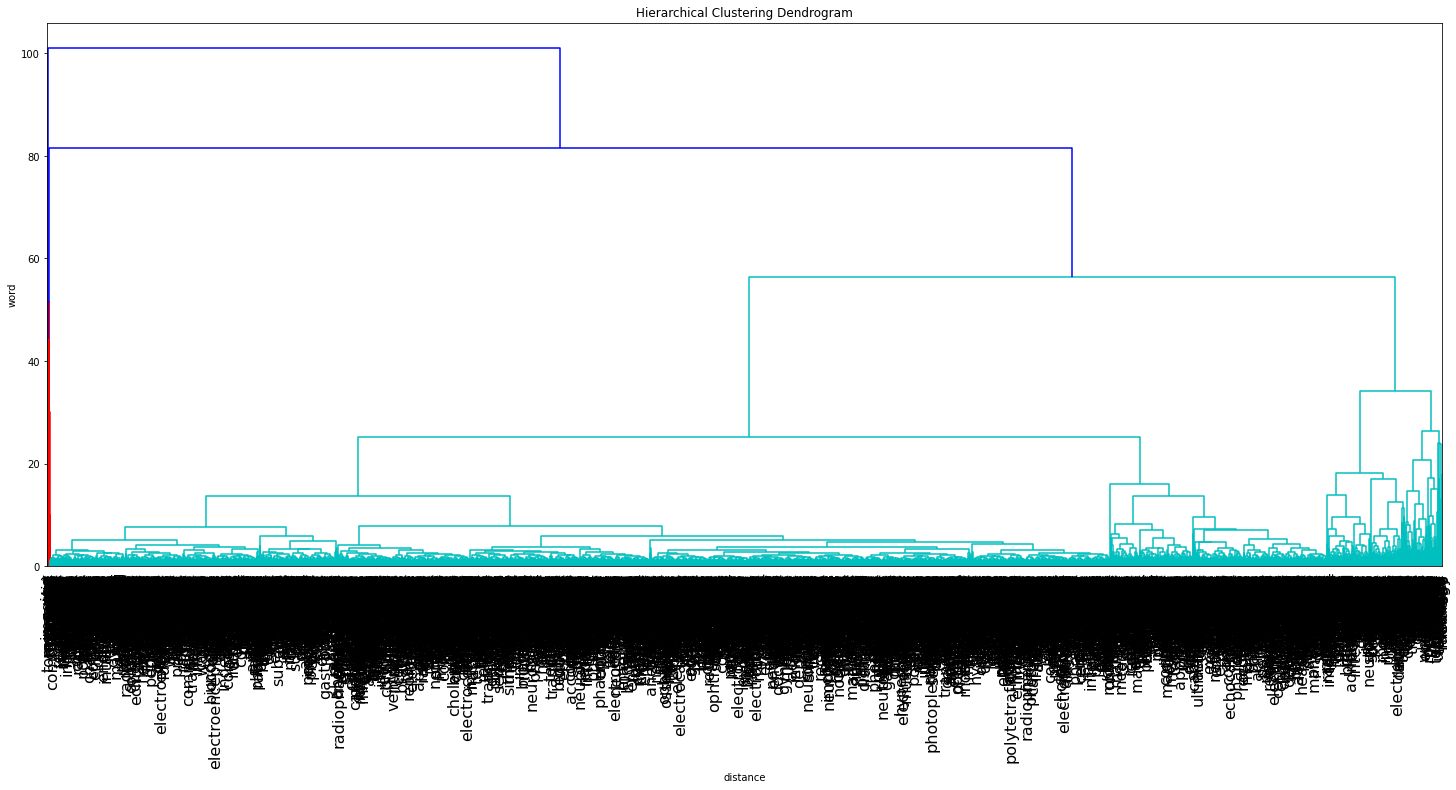

In [69]:
#plotting dendogram
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

l = linkage(Word2Vecmodel.wv.syn0, method='complete', metric='seuclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
    orientation='top',
    show_leaf_counts ='descending',
    leaf_label_func=lambda v: str(Word2Vecmodel.wv.index2word[v])
)
plt.show()